Copyright (C) 2024  Adam Jones  All Rights Reserved

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import figure_standard
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os

In [2]:
n_boot = 10001
figure_standard.standardize_plot_settings()
main_palette = figure_standard.create_main_palette()

In [3]:
df = pd.read_excel("../2_intermediate_data/main_model_data.xlsx")

In [4]:
studies = ["CCSHS", "CFS", "CHAT", "MESA", "WSC"]

In [5]:
df.loc[df["study"] == "ccshs", "study"] = "CCSHS"
df.loc[df["study"] == "cfs", "study"] = "CFS"
df.loc[df["study"] == "chat", "study"] = "CHAT"
df.loc[df["study"] == "mesa", "study"] = "MESA"
df.loc[df["study"] == "wsc", "study"] = "WSC"

In [6]:
df["decade_str"] = ""
for i, l in enumerate(reversed(["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"])):
    df.loc[df["decade"] == (i + 1), "decade_str"] = l

In [7]:
df = df.sort_values(by=["decade_str", "study"], ascending=[True, True])
df["weight"] = 1

In [8]:
# add some fake rows so that the studies are ordered correctly (weight=0)
df_fake = pd.DataFrame(columns=df.keys())

for i, study in enumerate(studies):
    df_fake.loc[i, "study"] = study
    df_fake.loc[i, "decade"] = df[df.study == study].decade_str.unique()[0]
    df_fake.loc[i, "weight"] = 0

df_full = pd.concat([df_fake, df], axis=0)

In [9]:
### c
df_stages = df[
    ["w_per_spt", "n1_per_spt", "n2_per_spt", "n3_per_spt", "rem_per_spt"]
].copy()
df_stages = df_stages.rename(
    columns={
        "w_per_spt": "Wake",
        "n1_per_spt": "N1",
        "n2_per_spt": "N2",
        "n3_per_spt": "N3",
        "rem_per_spt": "REM",
    }
)

df_stages = 100 * df_stages

In [10]:
### d
df_all = pd.read_excel("../2_intermediate_data/all_recordings_by_epoch.xlsx")
df_all["rec_count"] = df_all["rec_count"] / 4000
data_per = pd.melt(
    df_all,
    id_vars=["epoch_i"],
    value_vars=(["wake_per", "n1_per", "n2_per", "n3_per", "rem_per", "rec_count"]),
)
data_per["value"] = 100 * data_per["value"]
# make a copy of the epoch_i
data_per["epoch_i_org"] = data_per["epoch_i"]
# in (X) 30-sec epochs
epoch_bin_size = 30

# relabel the epoch_i to get stats on each
data_per["epoch_i"] = data_per["epoch_i_org"].apply(lambda x: int(x / epoch_bin_size))

data_per["time_hr"] = (
    (data_per["epoch_i"] + 1) * epoch_bin_size - epoch_bin_size / 2
) * (30 / 3600)

In [11]:
### e
df_per = pd.melt(
    df,
    id_vars=["decade"],
    value_vars=(["w_per_spt", "n1_per_spt", "n2_per_spt", "n3_per_spt", "rem_per_spt"]),
)

df_per["value"] = 100 * df_per["value"]

In [12]:
### f
df_census = pd.read_excel("../2_intermediate_data/census.xlsx")
set_names = ["training", "validation", "testing"]

set_decade_counts = (
    df.groupby(["set", "decade"])["id"]
    .count()
    .unstack(fill_value=0)
    .to_numpy(dtype=float)
)
decade_counts = set_decade_counts.sum(0) / set_decade_counts.sum()

# create a dataframe for age
df_age = pd.DataFrame(columns=["decade", "percent"])
# for set in range(3):
for decade in range(10):
    df_age.loc[len(df_age)] = [(decade + 1), 100 * decade_counts[decade]]
df_age["decade"] = df_age["decade"].astype(int)

set_decade_counts_male = (
    df[df.male == 1]
    .groupby(["set", "decade"])["id"]
    .count()
    .unstack(fill_value=0)
    .to_numpy(dtype=float)
)
decade_counts_male = set_decade_counts_male.sum(0) / set_decade_counts.sum(0)

# create a dataframe for sex
df_sex = pd.DataFrame(columns=["decade", "percent"])
# for set in range(3):
for decade in range(10):
    df_sex.loc[len(df_sex)] = [(decade + 1), 100 * decade_counts_male[decade]]
df_sex["decade"] = df_sex["decade"].astype(int)

df_census["dummy"] = 1
df_sex["dummy"] = 1
df_age["dummy"] = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


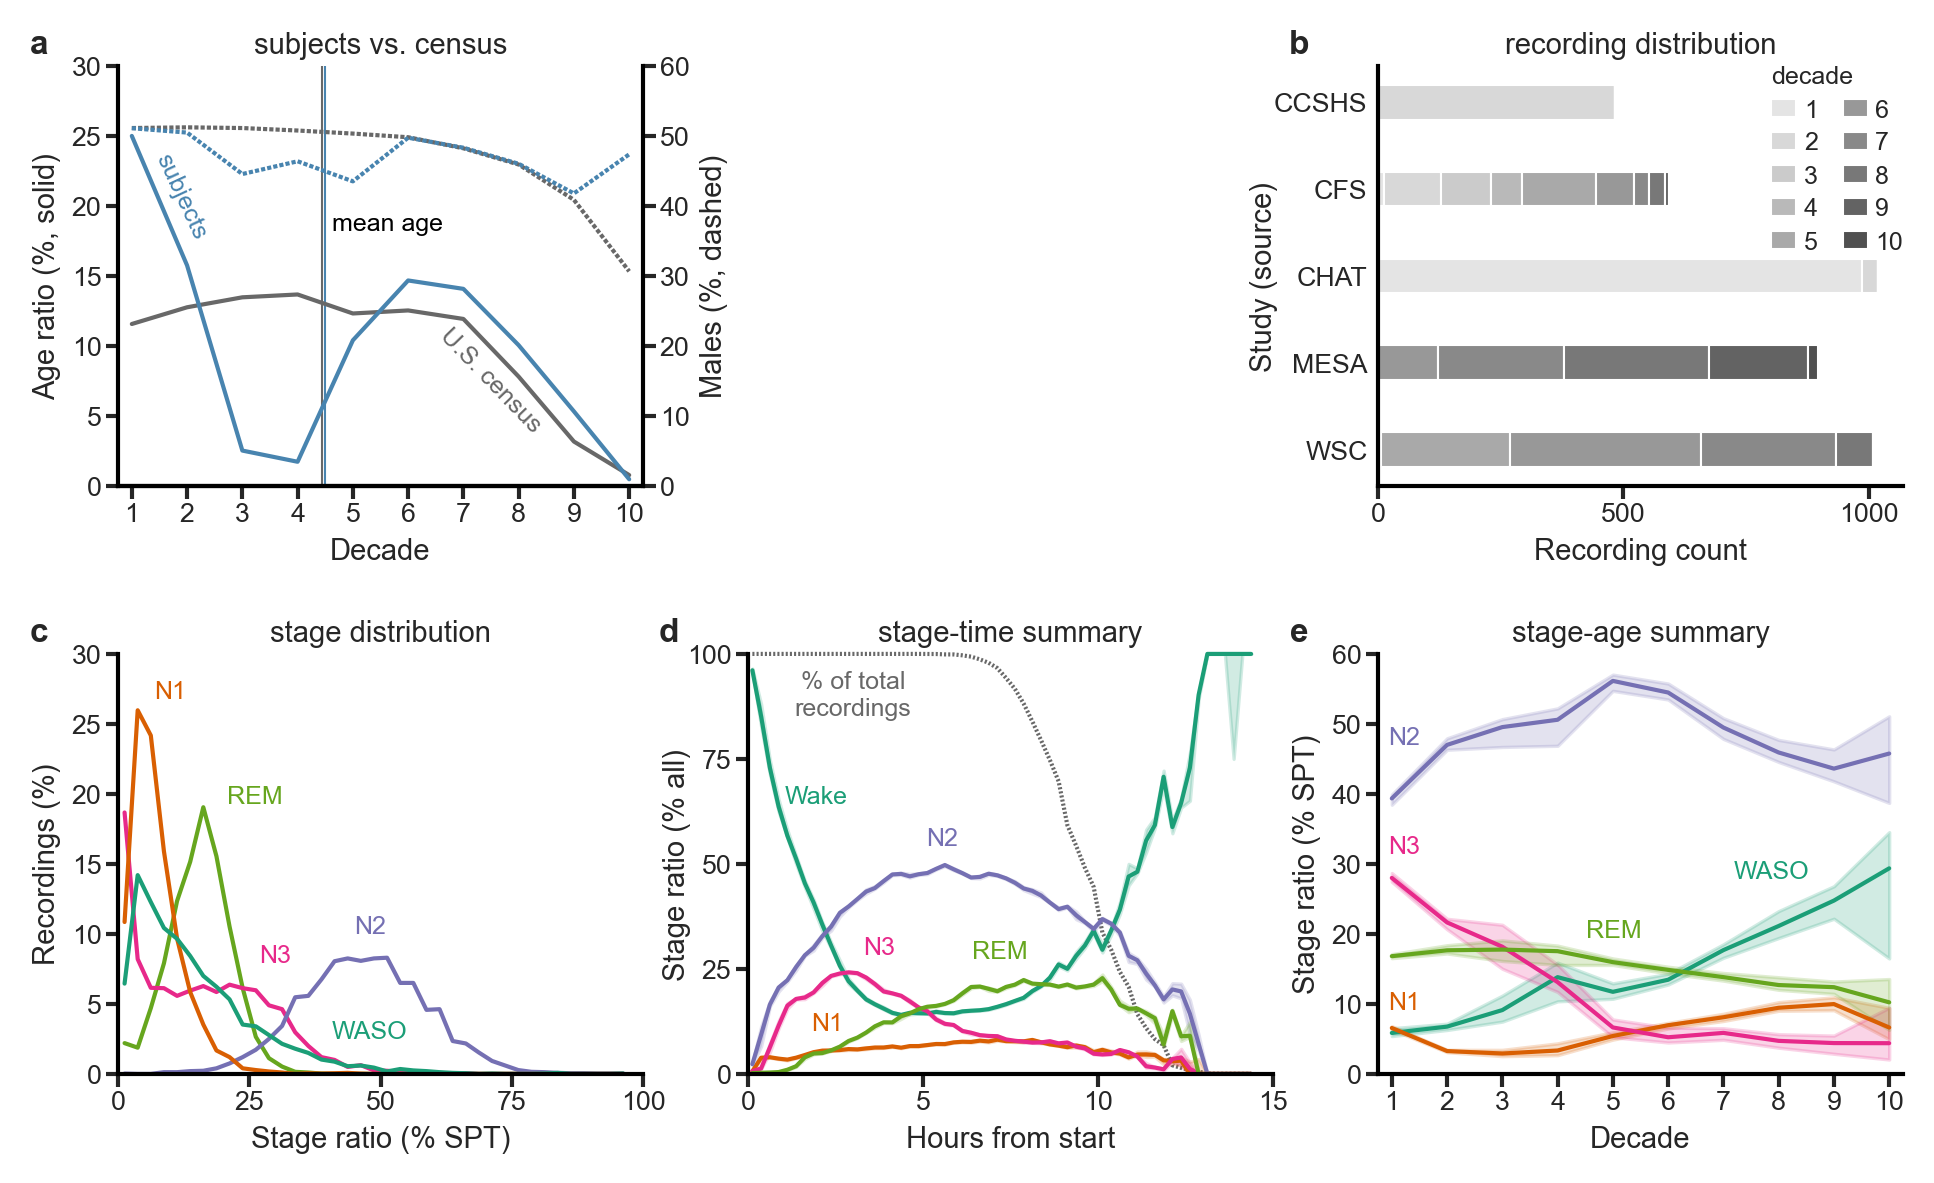

In [13]:

gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.4, 1])

ax5 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 2])
ax2 = plt.subplot(gs[2, 0])
ax3 = plt.subplot(gs[2, 1])
ax4 = plt.subplot(gs[2, 2])


### b ###


sns.histplot(
    data=df_full,
    y="study",
    hue="decade_str",
    multiple="stack",
    #   hue_order=[str(x) for x in range(1,11)],
    stat="count",
    weights="weight",
    shrink=0.4,
    legend=True,
    linewidth=0.5,
    cbar_kws=dict(linewidth=2),
    ax=ax1,
    palette=sns.color_palette("Greys_r", 12)[:-2],
)

ax1.set_xticks([0, 500, 1000])

handles = ax1.get_legend().legend_handles
labels = [str(x) for x in range(1, 11)]
ax1.legend(
    reversed(handles),
    labels,
    title="decade",
    title_fontproperties={"weight": None, "size": 6},
    loc="upper right",
    alignment="left",
    handletextpad=0.3,
    ncols=2,
    columnspacing=1,
    handlelength=1,
    borderpad=0,
    borderaxespad=0,
    labelspacing=0.4,
    fontsize=6,
)

labelpad = 2.5
ax1.set_ylabel("Study (source)", fontweight=None, labelpad=-1)
ax1.set_xlabel("Recording count", fontweight=None, labelpad=labelpad)

sns.despine(ax=ax1, right=True, top=True, bottom=False)
ax1.grid(False)
ax1.tick_params(axis="y", width=1, length=1.5, pad=1)
ax1.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)


### c ###

bins = np.arange(0, 100, 2.5)
sns.histplot(
    data=df_stages,
    element="poly",
    bins=bins,
    palette=main_palette[1:],
    legend=False,
    linewidth=1,
    ax=ax2,
    common_norm=False,
    stat="percent",
    fill=False,
)


ax2.set_xlim([0, 100])
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))

ax2.set_ylim([0, 30])
ax2.yaxis.set_major_locator(plt.MaxNLocator(6))


ax2.legend().remove()
ax2.text(
    0.48,
    0.10,
    "WASO",
    transform=ax2.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[1],
)

ax2.text(
    0.10,
    0.91,
    "N1",
    transform=ax2.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[2],
)

ax2.text(
    0.48,
    0.35,
    "N2",
    transform=ax2.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[3],
)

ax2.text(
    0.30,
    0.28,
    "N3",
    transform=ax2.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[4],
)

ax2.text(
    0.26,
    0.66,
    "REM",
    transform=ax2.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[5],
)


sns.despine(ax=ax2, right=True, top=True, bottom=False)
ax2.grid(False)
ax2.tick_params(axis="y", left=True, width=1, length=3, pad=1)
ax2.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)


labelpad = 2.5
ax2.set_xlabel("Stage ratio (% SPT)", fontweight=None, labelpad=labelpad)
ax2.set_ylabel("Recordings (%)", fontweight=None, labelpad=labelpad)


### d ###

recordings_color = sns.color_palette("Greys", 5)[3]


sns.lineplot(
    data=data_per[data_per.variable != "rec_count"],
    x="time_hr",
    y="value",
    linewidth=1,
    palette=main_palette[1:],
    hue_order=["wake_per", "n1_per", "n2_per", "n3_per", "rem_per"],
    clip_on=False,
    markers=False,
    estimator="median",
    n_boot=n_boot,
    ax=ax3,
    hue="variable",
)

# draw the recording count separately, so that the errorbar can be removed
sns.lineplot(
    data=data_per[data_per.variable == "rec_count"],
    x="time_hr",
    y="value",
    linewidth=1,
    palette=[recordings_color],
    hue_order=["rec_count"],
    clip_on=False,
    style="variable",
    markers=False,
    estimator="median",
    n_boot=n_boot,
    errorbar=None,
    dashes=[(0.5, 0.5)],
    hue="variable",
    ax=ax3,
)

ax3.set_ylim((0, 100))
ax3.yaxis.set_major_locator(plt.MaxNLocator(4))

ax3.set_xlim((0, 15))
ax3.set_xticks([0, 5, 10, 15])

for child in ax3._children:
    try:
        if child._dash_pattern[1][1] == 0.5:
            child.zorder = 0.5
    except:
        pass

ax3.get_legend().remove()

sns.despine(ax=ax3, right=True, top=True, bottom=False)
ax3.grid(False)
ax3.tick_params(axis="y", left=True, width=1, length=3, pad=1)
ax3.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)

labelpad = 2.5
ax3.set_ylabel("Stage ratio (% all)", fontweight=None, labelpad=-1)
ax3.set_xlabel("Hours from start", fontweight=None, labelpad=labelpad)

ax3.text(
    0.07,
    0.66,
    "Wake",
    transform=ax3.transAxes,
    fontsize=6,
    va="center",
    ha="left",
    color=main_palette[1],
)

ax3.text(
    0.15,
    0.12,
    "N1",
    transform=ax3.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[2],
)

ax3.text(
    0.37,
    0.56,
    "N2",
    transform=ax3.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[3],
)

ax3.text(
    0.25,
    0.3,
    "N3",
    transform=ax3.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[4],
)

ax3.text(
    0.48,
    0.29,
    "REM",
    transform=ax3.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[5],
)

ax3.text(
    0.20,
    0.96,
    "% of total\nrecordings",
    transform=ax3.transAxes,
    fontsize=6,
    va="top",
    ha="center",
    color=recordings_color,
)


### e ###

sns.lineplot(
    data=df_per,
    x="decade",
    y="value",
    linewidth=1,
    palette=main_palette[1:],
    n_boot=n_boot,
    estimator="median",
    clip_on=False,
    ax=ax4,
    hue="variable",
)

ax4.set_ylim([0, 60])
ax4.yaxis.set_major_locator(plt.MaxNLocator(6))

ax4.set_xlim([0.75, 10.25])
ax4.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

sns.despine(ax=ax4, right=True, top=True, bottom=False)
ax4.grid(False)
ax4.tick_params(axis="y", left=True, width=1, length=3, pad=1)
ax4.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)

labelpad = 2.5
ax4.set_ylabel("Stage ratio (% SPT)", fontweight=None, labelpad=labelpad)
ax4.set_xlabel("Decade", fontweight=None, labelpad=labelpad)


ax4.legend().remove()


ax4.text(
    0.75,
    0.48,
    "WASO",
    transform=ax4.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[1],
)

ax4.text(
    0.02,
    0.17,
    "N1",
    transform=ax4.transAxes,
    fontsize=6,
    va="center",
    ha="left",
    color=main_palette[2],
)

ax4.text(
    0.02,
    0.80,
    "N2",
    transform=ax4.transAxes,
    fontsize=6,
    va="center",
    ha="left",
    color=main_palette[3],
)

ax4.text(
    0.02,
    0.54,
    "N3",
    transform=ax4.transAxes,
    fontsize=6,
    va="center",
    ha="left",
    color=main_palette[4],
)

ax4.text(
    0.45,
    0.34,
    "REM",
    transform=ax4.transAxes,
    fontsize=6,
    va="center",
    ha="center",
    color=main_palette[5],
)


### f ###

palette = sns.color_palette("Greys", 5)[3:4]

sns.lineplot(
    data=df_census,
    x="decade",
    y="age_percent",
    linewidth=1,
    hue="dummy",
    legend=False,
    palette=palette,
    ax=ax5,
)

sns.lineplot(
    data=df_age,
    x="decade",
    y="percent",
    hue="dummy",
    linewidth=1,
    legend=False,
    palette=[main_palette[0]],
    ax=ax5,
)


ax5.set_ylim([0, 30])
ax5.set_xlim([0.75, 10.25])
ax5.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax5.yaxis.set_major_locator(plt.MaxNLocator(6))

ax5_2 = ax5.twinx()
dash_style = (1, 0.5)
sns.lineplot(
    data=df_census,
    x="decade",
    y="male_percent",
    linewidth=1,
    hue="dummy",
    legend=False,
    palette=palette,
    dashes=dash_style,
    ax=ax5_2,
)

sns.lineplot(
    data=df_sex,
    x="decade",
    y="percent",
    hue="dummy",
    linewidth=1,
    palette=[main_palette[0]],
    dashes=dash_style,
    legend=False,
    ax=ax5_2,
)

ax5_2.set_ylim([0, 60])
ax5_2.yaxis.set_major_locator(plt.MaxNLocator(6))

labelpad = 2.5
ax5.set_xlabel("Decade", fontweight=None, labelpad=labelpad)
ax5.set_ylabel("Age ratio (%, solid)", fontweight=None, labelpad=labelpad)
ax5_2.set_ylabel("Males (%, dashed)", fontweight=None, labelpad=labelpad)

sns.despine(ax=ax5, right=True, top=True, bottom=False)
sns.despine(ax=ax5_2, right=False, top=True, bottom=False, left=True)
ax5.grid(False)
ax5_2.grid(False)
ax5.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)
ax5.tick_params(axis="y", left=True, width=1, length=3, pad=1)
ax5_2.tick_params(axis="y", right=True, width=1, length=3, pad=1)


ax5.text(
    0.71,
    0.385,
    "U.S. census",
    transform=ax5.transAxes,
    fontsize=6,
    va="top",
    ha="center",
    color=palette[0],
).set_rotation(-46)
ax5.text(
    0.12,
    0.80,
    "subjects",
    transform=ax5.transAxes,
    fontsize=6,
    va="top",
    ha="center",
    color=main_palette[0],
).set_rotation(-65)
ax5.text(
    0.407,
    0.65,
    "mean age",
    transform=ax5.transAxes,
    fontsize=6,
    va="top",
    ha="left",
    color="black",
)

ax5.axvline(
    x=4.44, color=palette[0], ymin=0, ymax=1, linewidth=0.5, linestyle="solid", zorder=0
)
ax5.axvline(
    x=4.49,
    color=main_palette[0],
    ymin=0,
    ymax=1,
    linewidth=0.5,
    linestyle="solid",
    zorder=0,
)


panel_label_y = 1.05
panel_label_x = -0.15
panel_fontsize = 8
ax5.text(
    panel_label_x,
    panel_label_y,
    "a",
    transform=ax5.transAxes,
    fontsize=panel_fontsize,
    fontweight="bold",
    va="center",
    ha="center",
)
ax1.text(
    panel_label_x,
    panel_label_y,
    "b",
    transform=ax1.transAxes,
    fontsize=panel_fontsize,
    fontweight="bold",
    va="center",
    ha="center",
)
ax2.text(
    panel_label_x,
    panel_label_y,
    "c",
    transform=ax2.transAxes,
    fontsize=panel_fontsize,
    fontweight="bold",
    va="center",
    ha="center",
)
ax3.text(
    panel_label_x,
    panel_label_y,
    "d",
    transform=ax3.transAxes,
    fontsize=panel_fontsize,
    fontweight="bold",
    va="center",
    ha="center",
)
ax4.text(
    panel_label_x,
    panel_label_y,
    "e",
    transform=ax4.transAxes,
    fontsize=panel_fontsize,
    fontweight="bold",
    va="center",
    ha="center",
)


panel_title_x = 0.5
title_fontsize = 7
ax5.text(
    panel_title_x,
    panel_label_y,
    "subjects vs. census",
    transform=ax5.transAxes,
    fontsize=title_fontsize,
    fontweight=None,
    va="center",
    ha="center",
)
ax1.text(
    panel_title_x,
    panel_label_y,
    "recording distribution",
    transform=ax1.transAxes,
    fontsize=title_fontsize,
    fontweight=None,
    va="center",
    ha="center",
)
ax2.text(
    panel_title_x,
    panel_label_y,
    "stage distribution",
    transform=ax2.transAxes,
    fontsize=title_fontsize,
    fontweight=None,
    va="center",
    ha="center",
)
ax3.text(
    panel_title_x,
    panel_label_y,
    "stage-time summary",
    transform=ax3.transAxes,
    fontsize=title_fontsize,
    fontweight=None,
    va="center",
    ha="center",
)
ax4.text(
    panel_title_x,
    panel_label_y,
    "stage-age summary",
    transform=ax4.transAxes,
    fontsize=title_fontsize,
    fontweight=None,
    va="center",
    ha="center",
)


plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.2)
figure_standard.scale_figure_by_axes(ax5, 1.4, 1.75)

# save the figure
filename = os.path.basename(globals()["__vsc_ipynb_file__"]).replace(".ipynb", "")
figure_standard.save_figure_files(filename)